In [12]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg


pd.set_option('display.max_columns', None)


# #Test on BTC data
BTC = pd.read_csv('data/BTC_daily.csv', index_col=0, parse_dates=True)
ETH = pd.read_csv('data/ETH_daily.csv', index_col=0, parse_dates=True)

In [13]:
#Concact 2 close price    
price_data = [BTC["Close"], ETH["Close"]]
headers = ["BTC", "ETH"]
price_df = pd.concat(price_data, axis=1, keys=headers).dropna()
display(price_df)

,BTC,ETH
date,,
2022-09-01,20133.65,1586.23
2022-09-02,19953.74,1575.69
2022-09-03,19835.47,1557.70
2022-09-04,20004.73,1579.04
2022-09-05,19794.58,1618.01
...,...,...
2024-07-28,68244.30,3269.98
2024-07-29,66771.45,3317.55
2024-07-30,66169.68,3278.27


In [14]:
# Regression
x = price_df['BTC']
Y = price_df['ETH']
x = sm.add_constant(x)
model = sm.OLS(Y, x)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    ETH   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 2.218e+04
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        22:34:12   Log-Likelihood:                -4430.6
No. Observations:                 701   AIC:                             8865.
Df Residuals:                     699   BIC:                             8874.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        544.4281     11.830     46.021      0.0

hedge ratio: 0.043461421516468736, hedge constant: 544.4281125466536
CADF:(-4.663626608260299, 9.843851449718441e-05, 5, 695, {'1%': -3.439794053189972, '5%': -2.8657075899001314, '10%': -2.56898934061384}, 6971.878254780801)
the p-value of 9.843851449718441e-05 is less than 1%
Proceed, stationary


/var/folders/cd/f8k7t0cj4ys82598qkc0bznr0000gn/T/ipykernel_7550/3978218189.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = result.params[1]
/var/folders/cd/f8k7t0cj4ys82598qkc0bznr0000gn/T/ipykernel_7550/3978218189.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_const = result.params[0]


<Axes: xlabel='date'>

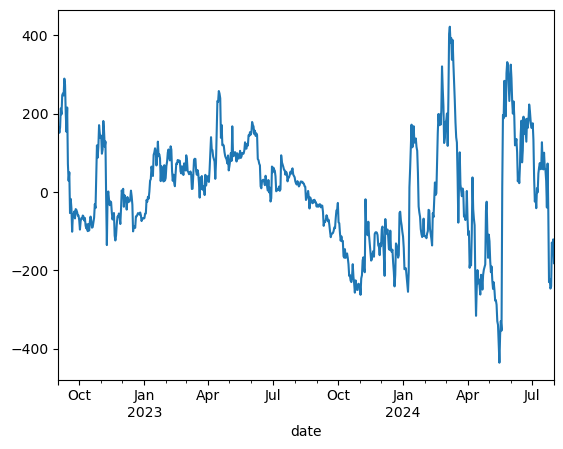

In [15]:
#Obtain hedging numbers
hedge_ratio = result.params[1]
hedge_const = result.params[0]
print(f'hedge ratio: {hedge_ratio}, hedge constant: {hedge_const}')

#Obtain residuals
residuals = result.resid

#Augumented Dickey-Fuller Test to check for staionarity of the spread
adf_test = adfuller(residuals)
print(f'CADF:{adf_test}')
if(adf_test[1] < 0.01):
    print(f'the p-value of {adf_test[1]} is less than 1%')
    print('Proceed, stationary')
else:
    print('Stop! non-stationary')

residuals.plot()

In [16]:
#Fitting the spread to OU model
# e_t = C + Be_t-1 + error
OU_model = AutoReg(residuals, lags=1)
result = OU_model.fit()
print(result.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  701
Model:                     AutoReg(1)   Log Likelihood               -3604.348
Method:               Conditional MLE   S.D. of innovations             41.685
Date:                Thu, 15 Aug 2024   AIC                           7214.696
Time:                        22:34:20   BIC                           7228.349
Sample:                    09-02-2022   HQIC                          7219.973
                         - 08-01-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4847      1.576     -0.308      0.758      -3.573       2.603
y.L1           0.9509      0.012     81.118      0.000       0.928       0.974
                                    Roots           

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [17]:
B = result.params['y.L1']
C = result.params['const']

# Compute OU parameters 
tau = 1/365 # Since we are analyzing daily data for crypto (market opens 365 days a year)
theta = -np.log(B)/tau
half_life = np.log(2)/theta


mu = C/(1-B)
sigma_eq = result.resid.std() * np.sqrt(1/(1-np.exp(-2 * theta * tau)))

print("tau:",tau)
print("theta:", theta)
print("half_life:", half_life)
print("number of days to revert:", half_life/tau)
print("mean:", mu)
print("sigma_equalibrium:", sigma_eq)

tau: 0.0027397260273972603
theta: 18.376099878201146
half_life: 0.037720037720419604
number of days to revert: 13.767813767953156
mean: -9.871082407722996
sigma_equalibrium: 134.78160525377615


In [18]:
print(f'-------Conclusion------\nTrade ETH against BTC: hedge ratio = {hedge_ratio}, hedge constant ={hedge_const}, residuals mean = {mu}, sigma_eq = {sigma_eq}')

-------Conclusion------
Trade ETH against BTC: hedge ratio = 0.043461421516468736, hedge constant =544.4281125466536, residuals mean = -9.871082407722996, sigma_eq = 134.78160525377615
